# MCMC: Telescope Observation

Let's build your first Markov Chain! 

You are a real astronomer (not a theory guy like me) and are planning an expensive observational campaign. You want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:

$$p({\rm clear \; tomorrow} \, |\,  {\rm cloudy \; today}) = 0.5,$$

which means that

$$p({\rm cloudy \; tomorrow} \, |\, {\rm cloudy \; today}) = 0.5.$$

We also have

$$p({\rm cloudy \; tomorrow} \, |\, {\rm clear \; today}) = 0.1,$$

which means that

$$p({\rm clear \; tomorrow} \, |\, {\rm clear \; today}) = 0.9.$$


- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree. 
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at

$$p({\rm clear}) = 0.83,$$

and 

$$p({\rm cloudy}) = 0.17.$$

You get the same answer for day $N$ as day $N+1$ and it doesn't matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are, indeed, a **MARKOV CHAIN**.

Here is an illustration of this process from an article in [towarddatascience.com](https://towardsdatascience.com/introduction-to-markov-chains-50da3645a50d).

![image.png](https://miro.medium.com/max/416/1*frksGjINf5oTjx7WL81U3w.png)

#### Tasks

- Start off on a cloud day. 
- Implement your weather forecast based on the above probabilities
- Run your simulator for N days (with $N\gtrsim 10^4$)
- Prepare a plot with the number of days on the x axis and the cumulative number of, say, sunny days over the number of days so far on the y axis. This is called a **trace-plot**, showing how our estimate of $p(\mathrm{clear})$ evolves as the chain samples.  
- Prepare a histogram of the above plot. This reveals the distribution of $p(\mathrm{clear})$.
- Use a summary statistics to determine the most likely value and an error on our estimate.

**Important:** 
- In MCMC the process must be **stationary** which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.  
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
- So, there is a **burn-in** phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, but ***you should always start with a traceplot of your samples!***


#### Tasks

- In the above example, experiment with chopping off different numbers of initial points as burn-in.


#### More

- Redo the same for the Markovian process describing the stock market (see above in this notebook). If you've written your code well, this should require minor modifications.

In [1]:
import scipy as scipy
from scipy.stats import uniform, norm
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns

### Set  the probabilities

In [56]:
p_clear = 0.83
p_cloud = 0.17

p_clear_tom_cloud_tod = 0.5
p_cloud_tom_cloud_tod = 0.5
p_cloud_tom_clear_tod = 0.1
p_clear_tom_clear_tod = 0.9

N_days = 100000

Clear day $\rightarrow$ 0

Cloud day $\rightarrow$ 1

Function that set the probabilities: 
- if it is cloudy (1), tomorrow will be cloudy/clear at $50\%$
- if it is clear (0), tomorrow will be cloudy at $10\%$ and clear at $90\%$

In [57]:
def Probabilities(current, proposed):
    if current == 1:        # Cloudy today --> 0.5 cloud/sunny
        return 0.5    
    
    if current == 0:        # Clear today --> 0.9 clear & 0.1 cloud
        if proposed == 1:                  
            return 0.1
        if proposed == 0:
            return 0.9

Forecast function: takes the number of days and the initial condition and returns an array with the forecast for the N days!

In [58]:
# This function implements the Metropolis-Hastings Algotithm
def Forecast(n_samples, initial_weather = 1):
    
    current_weather = initial_weather
    posterior = [initial_weather]
    
    for i in tqdm(range(n_samples)):
        # Proposed value for theta_{i+1}
        proposed_weather = np.random.randint(0, 2)

        # Compute the acceptance probability
        p_accept = Probabilities(current_weather, proposed_weather)

        # Draw a random number between 0 and 1 from a uniform distribution
        accept = uniform.rvs() < p_accept
        
        # If  it is smaller than p_accept, add it to the chain 
        if accept:
            current_weather = proposed_weather
            
        posterior.append(current_weather)
        
    return np.array(posterior)

In [59]:
posterior = Forecast(n_samples=N_days, initial_weather=1)

100%|████████████████████████████████| 100000/100000 [00:04<00:00, 21574.26it/s]


In [60]:
posterior

array([1, 0, 0, ..., 0, 0, 0])

In [61]:
clear_prob = np.count_nonzero(posterior==0)/N_days
cloud_prob = np.count_nonzero(posterior==1)/N_days

In [62]:
print(f'P_clear = {100*clear_prob:.2f} %')
print(f'P_cloud = {100*cloud_prob:.2f} %')

P_clear = 83.39 %
P_cloud = 16.61 %


Here I compute the probability of the sky to be clear or cloudy after N days with N from 1 to N_days!

In [63]:
N_days = []
Cloud_p = []
Clear_p = []

for i in range(1, len(posterior)):
    N_days.append(i)
    Clear_p.append(np.count_nonzero(posterior[:i] == 0)/i)
    Cloud_p.append(np.count_nonzero(posterior[:i] == 1)/i)

N_days = np.array(N_days)
Clear_p = np.array(Clear_p)
Cloud_p = np.array(Cloud_p)

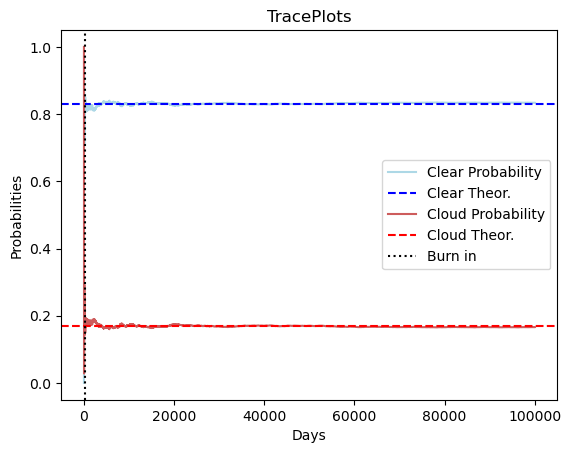

In [64]:
plt.plot(N_days, Clear_p, color='lightblue', label='Clear Probability')
plt.axhline(y=p_clear, linestyle='--', color='Blue', label='Clear Theor.' )
plt.plot(N_days, Cloud_p, color='indianred', label='Cloud Probability')
plt.axhline(y=p_cloud, linestyle='--', color='Red', label='Cloud Theor.' )
plt.axvline(x=200, linestyle='dotted', color='black', label='Burn in')

plt.title('TracePlots')
plt.xlabel('Days')
plt.ylabel('Probabilities')
plt.legend()

### Zoom in

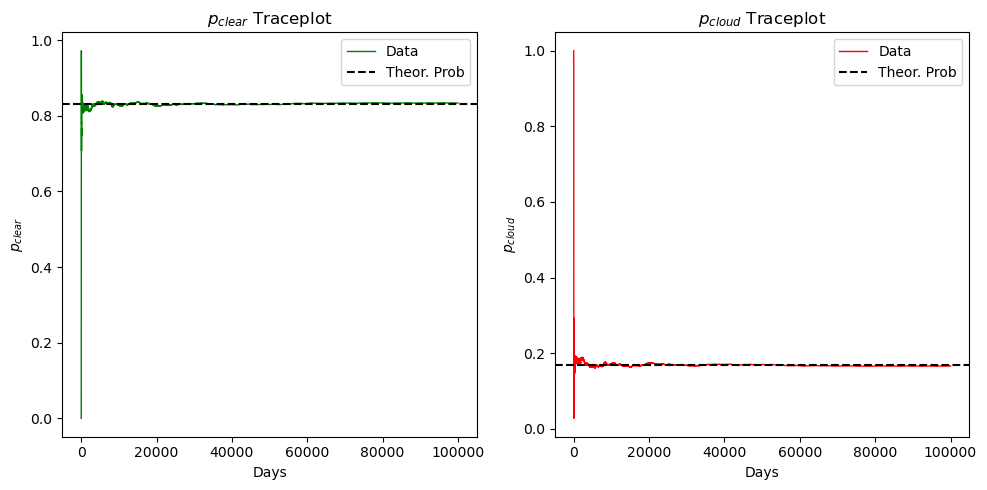

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot sul primo subplot
axs[0].plot(N_days, Clear_p, label='Data', color='green', linewidth=1.0)
axs[0].axhline(y=p_clear, color='black', linestyle='--', label='Theor. Prob')
axs[0].set_title('$p_{clear}$ Traceplot')
axs[0].set_xlabel('Days')
axs[0].set_ylabel('$p_{clear}$')
axs[0].legend()

# Plot sul secondo subplot
axs[1].plot(N_days, Cloud_p, label='Data', color='red', linewidth=1.0)
axs[1].axhline(y=p_cloud, color='black', linestyle='--', label='Theor. Prob')
axs[1].set_title('$p_{cloud}$ Traceplot')
axs[1].set_xlabel('Days')
axs[1].set_ylabel('$p_{cloud}$')
axs[1].legend()

# Mostra il grafico
plt.tight_layout()

## Histograms

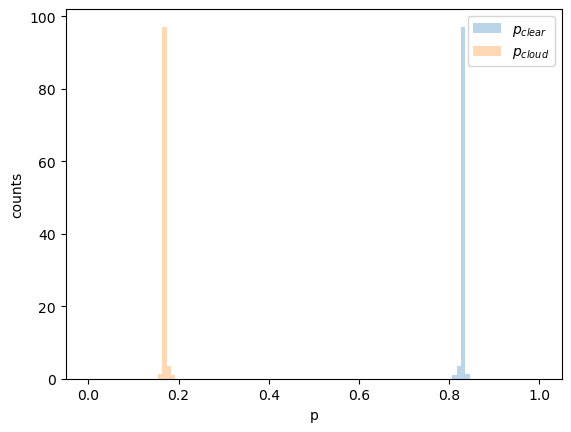

In [66]:
plt.hist(Clear_p, bins=100, alpha=0.3, density=True, label='$p_{clear}$')
plt.hist(Cloud_p, bins=100, alpha=0.3, density=True, label='$p_{cloud}$')

plt.xlabel('p')
plt.ylabel('counts')
plt.legend()

### ZOOM in

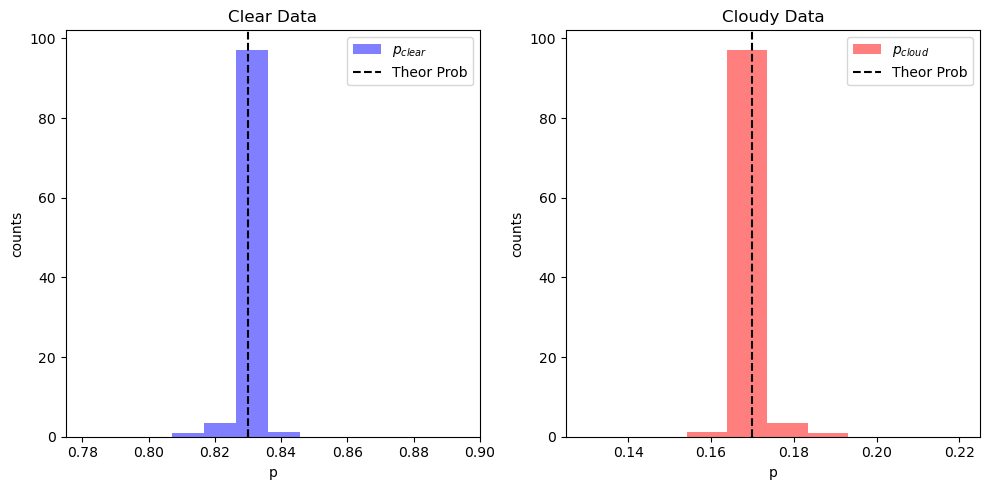

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot sul primo subplot (Clear_p e Clear_p_200)
axs[0].hist(Clear_p, bins=100, alpha=0.5, density=True, color='blue', label='$p_{clear}$')
axs[0].axvline(x=p_clear, color='Black', linestyle='--', label='Theor Prob')
axs[0].set_title('Clear Data')
axs[0].set_xlabel('p')
axs[0].set_ylabel('counts')
axs[0].set_xlim(0.775, 0.90)
axs[0].legend()

# Plot sul secondo subplot (Cloud_p e Cloud_p_200)
axs[1].hist(Cloud_p, bins=100, alpha=0.5, density=True, color='red', label='$p_{cloud}$')
axs[1].axvline(x=p_cloud, color='Black', linestyle='--', label='Theor Prob')
axs[1].set_title('Cloudy Data')
axs[1].set_xlabel('p')
axs[1].set_ylabel('counts')
axs[1].set_xlim(0.125, 0.225)
axs[1].legend()

# Mostra il grafico
plt.tight_layout()

In [68]:
mean_p_clear = np.mean(Clear_p)
mean_p_cloud = np.mean(Cloud_p)

print(f'Mean_P_clear = {100*mean_p_clear:.2f} %')
print(f'Mean_P_cloud = {100*mean_p_cloud:.2f} %')

Mean_P_clear = 83.17 %
Mean_P_cloud = 16.83 %


### Discard some points
We can notice that at the beginning, the probabilities do not follow the expected behaviour, so let's try not to take into account the first 1000 days and see what happens! 

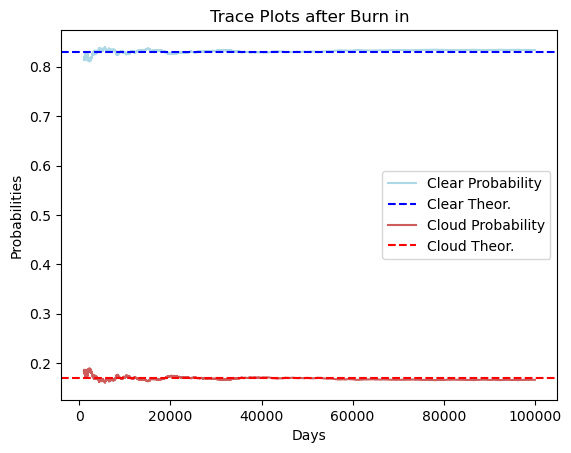

In [69]:
plt.plot(N_days[1000:], Clear_p[1000:], color='lightblue', label='Clear Probability')
plt.axhline(y=p_clear, linestyle='--', color='Blue', label='Clear Theor.' )
plt.plot(N_days[1000:], Cloud_p[1000:], color='indianred', label='Cloud Probability')
plt.axhline(y=p_cloud, linestyle='--', color='Red', label='Cloud Theor.' )

plt.xlabel('Days')
plt.ylabel('Probabilities')
plt.title('Trace Plots after Burn in')
plt.legend()

### Zoom in

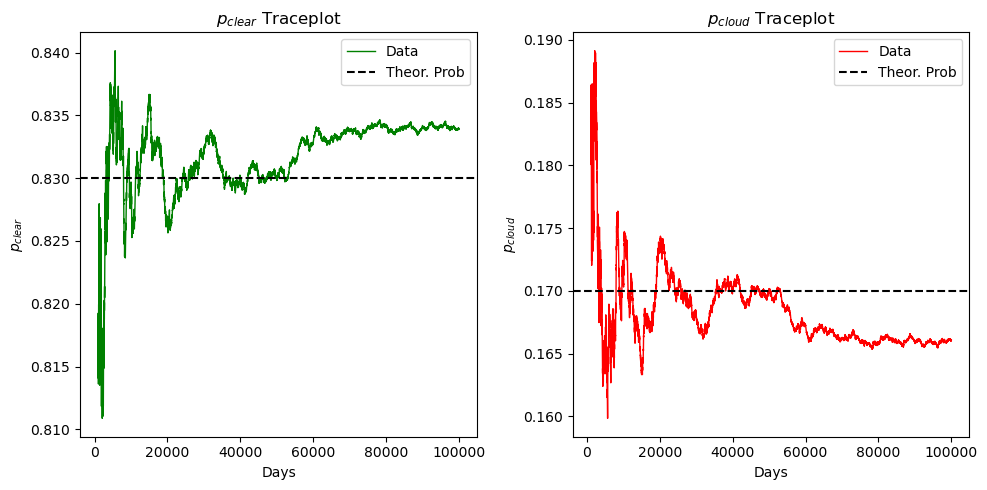

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot sul primo subplot
axs[0].plot(N_days[1000:], Clear_p[1000:], label='Data', color='green', linewidth=1.0)
axs[0].axhline(y=p_clear, color='black', linestyle='--', label='Theor. Prob')
axs[0].set_title('$p_{clear}$ Traceplot')
axs[0].set_xlabel('Days')
axs[0].set_ylabel('$p_{clear}$')
axs[0].legend()

# Plot sul secondo subplot
axs[1].plot(N_days[1000:], Cloud_p[1000:], label='Data', color='red', linewidth=1.0)
axs[1].axhline(y=p_cloud, color='black', linestyle='--', label='Theor. Prob')
axs[1].set_title('$p_{cloud}$ Traceplot')
axs[1].set_xlabel('Days')
axs[1].set_ylabel('$p_{cloud}$')
axs[1].legend()

# Mostra il grafico
plt.tight_layout()

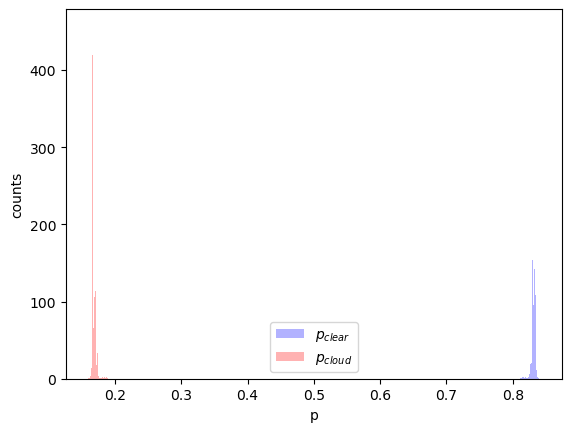

In [74]:
plt.hist(Clear_p[1000:], bins=100, alpha=0.3, density=True, color='Blue', label='$p_{clear}$')
plt.hist(Cloud_p[1000:], bins=100, alpha=0.3, density=True, color='Red',  label='$p_{cloud}$')

plt.xlabel('p')
plt.ylabel('counts')
plt.legend()

In [76]:
mean_p_clear_200 = np.mean(Clear_p[200:])
mean_p_cloud_200 = np.mean(Cloud_p[200:])

print(f'Mean_P_clear = {100*mean_p_clear_200:.2f} %')
print(f'Mean_P_cloud = {100*mean_p_cloud_200:.2f} %')

Mean_P_clear = 83.17 %
Mean_P_cloud = 16.83 %


Let's try to superimpose the histograms!

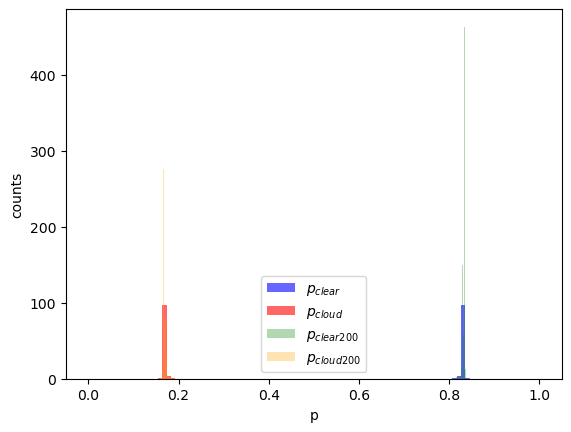

In [77]:
plt.hist(Clear_p, bins=100, alpha=0.6, density=True, color='blue', label='$p_{clear}$')
plt.hist(Cloud_p, bins=100, alpha=0.6, density=True, color='red', label='$p_{cloud}$')
plt.hist(Clear_p[200:], bins=100, alpha=0.3, density=True, color='green', label='$p_{clear200}$')
plt.hist(Cloud_p[200:], bins=100, alpha=0.3, density=True, color='orange', label='$p_{cloud200}$')

# Adding labels and legend
plt.xlabel('p')
plt.ylabel('counts')
plt.legend()


### Let's ZOOM in

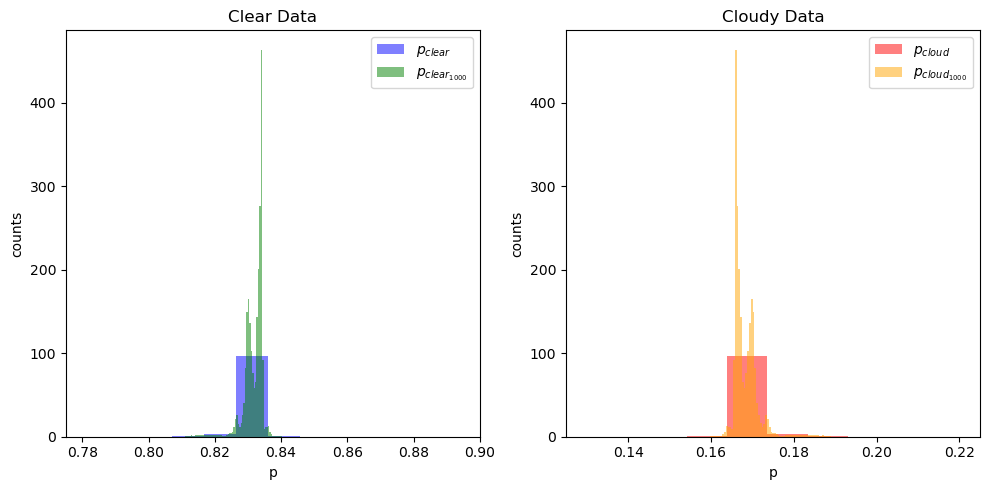

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot sul primo subplot (Clear_p e Clear_p_200)
axs[0].hist(Clear_p, bins=100, alpha=0.5, density=True, color='blue', label='$p_{clear}$')
axs[0].hist(Clear_p[200:], bins=100, alpha=0.5, density=True, color='green', label='$p_{clear_{1000}}$')
axs[0].set_title('Clear Data')
axs[0].set_xlabel('p')
axs[0].set_ylabel('counts')
axs[0].set_xlim(0.775, 0.90)
axs[0].legend()

# Plot sul secondo subplot (Cloud_p e Cloud_p_200)
axs[1].hist(Cloud_p, bins=100, alpha=0.5, density=True, color='red', label='$p_{cloud}$')
axs[1].hist(Cloud_p[200:], bins=100, alpha=0.5, density=True, color='orange', label='$p_{cloud_{1000}}$')
axs[1].set_title('Cloudy Data')
axs[1].set_xlabel('p')
axs[1].set_ylabel('counts')
axs[1].set_xlim(0.125, 0.225)
axs[1].legend()

# Mostra il grafico
plt.tight_layout()

## Errors

In [79]:
print(f'68 % Credibility Interval for p_clear: ({np.percentile(Clear_p[200:], 16)}, {np.percentile(Clear_p[200:], 84)}).')
print(f'68 % Credibility Interval for p_cloud: ({np.percentile(Cloud_p[200:], 16)}, {np.percentile(Cloud_p[200:], 84)}).')

68 % Credibility Interval for p_clear: (0.8296855110885447, 0.834039565680591).
68 % Credibility Interval for p_cloud: (0.165960434319409, 0.17031448891145523).
